In [204]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Bengaluru Ride Hailing Analysis") \
    .getOrCreate()



In [205]:
df = spark.read.csv("/content/Bengaluru Ola.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)


root
 |-- Date: string (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Booking ID: string (nullable = true)
 |-- Booking Status: string (nullable = true)
 |-- Customer ID: integer (nullable = true)
 |-- Vehicle Type: string (nullable = true)
 |-- Pickup Location: string (nullable = true)
 |-- Drop Location: string (nullable = true)
 |-- Avg VTAT: double (nullable = true)
 |-- Avg CTAT: double (nullable = true)
 |-- Cancelled  by Customer: integer (nullable = true)
 |-- Reason for Cancelling by Customer: string (nullable = true)
 |-- Cancelled Rides by Driver: integer (nullable = true)
 |-- Reason for Cancelling by Driver: string (nullable = true)
 |-- Incomplete Rides: integer (nullable = true)
 |-- Incomplete Rides Reason: string (nullable = true)
 |-- Booking Value: double (nullable = true)
 |-- Payment Method: string (nullable = true)
 |-- Ride Distance: double (nullable = true)
 |-- Driver Ratings: double (nullable = true)
 |-- Customer Rating: double (nullable = true

In [206]:
from pyspark.sql.functions import col

df.select([col(c).isNull().alias(c) for c in df.columns]).show(5)

df_cleaned = df.na.drop(subset=["Booking ID", "Booking Status", "Pickup Location", "Drop Location"])
df_filled = df_cleaned.fillna({
    "Driver Ratings": 0,
    "Customer Rating": 0,
    "Reason for Cancelling by Customer": "Not Provided",
    "Reason for Cancelling by Driver": "Not Provided",
    "Incomplete Rides Reason": "Not Provided"
})



+-----+-----+----------+--------------+-----------+------------+---------------+-------------+--------+--------+----------------------+---------------------------------+-------------------------+-------------------------------+----------------+-----------------------+-------------+--------------+-------------+--------------+---------------+
| Date| Time|Booking ID|Booking Status|Customer ID|Vehicle Type|Pickup Location|Drop Location|Avg VTAT|Avg CTAT|Cancelled  by Customer|Reason for Cancelling by Customer|Cancelled Rides by Driver|Reason for Cancelling by Driver|Incomplete Rides|Incomplete Rides Reason|Booking Value|Payment Method|Ride Distance|Driver Ratings|Customer Rating|
+-----+-----+----------+--------------+-----------+------------+---------------+-------------+--------+--------+----------------------+---------------------------------+-------------------------+-------------------------------+----------------+-----------------------+-------------+--------------+-------------+---

In [207]:
from pyspark.sql.functions import mean

mean_driver_rating = df_cleaned.select(mean("Driver Ratings")).first()[0]
mean_customer_rating = df_cleaned.select(mean("Customer Rating")).first()[0]

df_filled = df_cleaned.fillna({
    "Driver Ratings": mean_driver_rating,
    "Customer Rating": mean_customer_rating,
    "Reason for Cancelling by Customer": "Not Provided",
    "Reason for Cancelling by Driver": "Not Provided",
    "Incomplete Rides Reason": "Not Provided"
})


In [208]:
df_filled.groupBy("Booking Status").count().show()


+--------------------+-----+
|      Booking Status|count|
+--------------------+-----+
|             Success|33484|
| Cancelled by Driver| 9610|
|Cancelled by Cust...| 3799|
|          Incomplete| 3106|
+--------------------+-----+



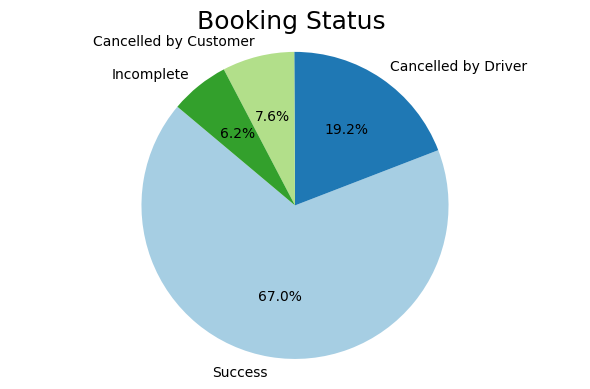

In [243]:
import matplotlib.pyplot as plt

booking_status_counts = df_filled.groupBy("Booking Status").count().toPandas()

labels = booking_status_counts["Booking Status"]
sizes = booking_status_counts["count"]

plt.figure(figsize=(6, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Booking Status ", fontsize=18)
plt.axis('equal')

plt.tight_layout()
plt.show()


In [210]:
df_filled.groupBy("Pickup Location").count().orderBy("count", ascending=False).show(5)
df_filled.groupBy("Drop Location").count().orderBy("count", ascending=False).show(5)


+---------------+-----+
|Pickup Location|count|
+---------------+-----+
|        Area-39| 1100|
|         Area-4| 1057|
|         Area-8| 1049|
|        Area-29| 1045|
|         Area-9| 1040|
+---------------+-----+
only showing top 5 rows

+-------------+-----+
|Drop Location|count|
+-------------+-----+
|      Area-39| 1058|
|       Area-8| 1052|
|      Area-21| 1049|
|      Area-34| 1042|
|      Area-27| 1041|
+-------------+-----+
only showing top 5 rows



In [211]:
df_filled.select("Driver Ratings", "Customer Rating").describe().show()


+-------+------------------+------------------+
|summary|    Driver Ratings|   Customer Rating|
+-------+------------------+------------------+
|  count|             49999|             49999|
|   mean| 4.003040258033963| 4.001726197586324|
| stddev|0.4743779204506678|0.4739660222707954|
|    min|               3.0|               3.0|
|    max|               5.0|               5.0|
+-------+------------------+------------------+



In [212]:
from pyspark.sql.functions import when

df_analysis = df_filled.withColumn("Completed Ride",
    when((col("Booking Status") == "Completed") & (col("Incomplete Rides") == 0), 1).otherwise(0)
)

df_analysis.groupBy("Completed Ride").count().show()


+--------------+-----+
|Completed Ride|count|
+--------------+-----+
|             0|49999|
+--------------+-----+



In [239]:
df.groupBy("Cancelled  by Customer").count().show()
df.groupBy("Cancelled Rides by Driver").count().show()


+----------------------+-----+
|Cancelled  by Customer|count|
+----------------------+-----+
|                     1| 3799|
|                     0|46200|
+----------------------+-----+

+-------------------------+-----+
|Cancelled Rides by Driver|count|
+-------------------------+-----+
|                        1| 9610|
|                        0|40389|
+-------------------------+-----+



In [215]:
df_filled.groupBy("Reason for Cancelling by Customer").count().orderBy("count", ascending=False).show()
df_filled.groupBy("Reason for Cancelling by Driver").count().orderBy("count", ascending=False).show()


+---------------------------------+-----+
|Reason for Cancelling by Customer|count|
+---------------------------------+-----+
|                     Not Provided|46200|
|             Driver is not mov...|  793|
|                AC is not working|  792|
|                  Change of plans|  756|
|             Driver asked to c...|  738|
|                    Wrong Address|  720|
+---------------------------------+-----+

+-------------------------------+-----+
|Reason for Cancelling by Driver|count|
+-------------------------------+-----+
|                   Not Provided|40389|
|           More than permitt...| 2512|
|           Personal & Car re...| 2413|
|           Customer related ...| 2402|
|           The customer was ...| 2283|
+-------------------------------+-----+



In [216]:
df.groupBy("Incomplete Rides").count().show()
df.groupBy("Incomplete Rides Reason").count().orderBy("count", ascending=False).show()


+----------------+-----+
|Incomplete Rides|count|
+----------------+-----+
|               1| 3106|
|               0|46893|
+----------------+-----+

+-----------------------+-----+
|Incomplete Rides Reason|count|
+-----------------------+-----+
|                   NULL|46893|
|        Customer Demand| 1091|
|            Other Issue| 1029|
|      Vehicle Breakdown|  986|
+-----------------------+-----+



In [217]:
from pyspark.sql.functions import sum

df_filled.select(sum("Booking Value")).show()
df_filled.groupBy("Payment Method").count().orderBy("count", ascending=False).show()


+--------------------+
|  sum(Booking Value)|
+--------------------+
|3.4266664589999974E7|
+--------------------+

+--------------+-----+
|Payment Method|count|
+--------------+-----+
|          NULL|16515|
|          Cash| 8552|
|           UPI| 8428|
|          Card| 8280|
|        Wallet| 8224|
+--------------+-----+



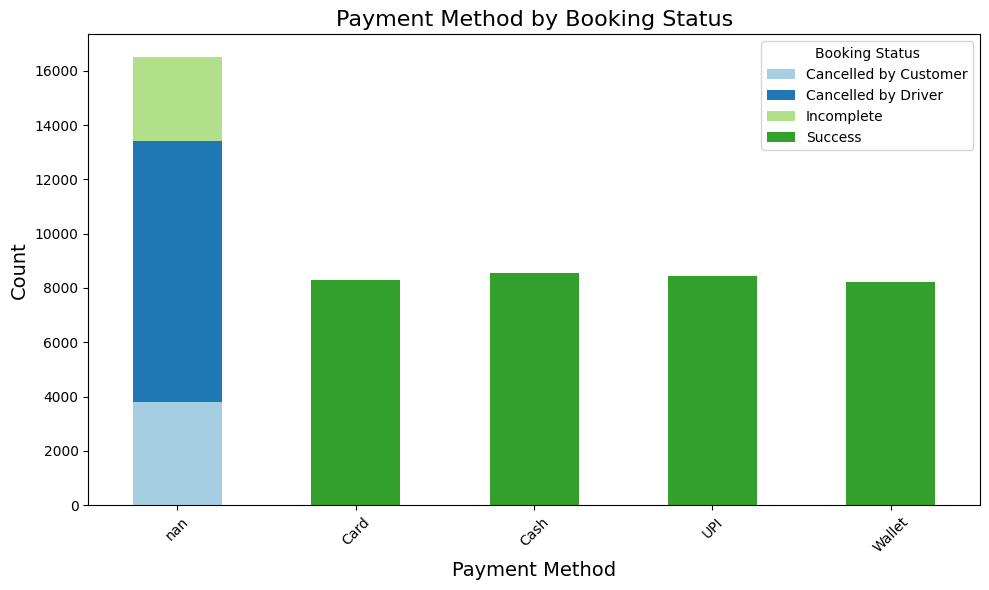

In [218]:
# Assuming 'Booking Status' and 'Payment Method' are available
payment_by_status = df_filled.groupBy("Payment Method", "Booking Status").count().toPandas()
payment_by_status_pivot = payment_by_status.pivot(index='Payment Method', columns='Booking Status', values='count')

payment_by_status_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), color=plt.cm.Paired.colors)
plt.title("Payment Method by Booking Status", fontsize=16)
plt.xlabel("Payment Method", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [219]:
df_filled.write.csv("cleaned_bangalore_railhailing.csv", header=True, mode="overwrite")


In [220]:
df_filled.select("Avg VTAT", "Avg CTAT").describe().show()

df_filled.stat.corr("Avg VTAT", "Avg CTAT")


+-------+-----------------+-----------------+
|summary|         Avg VTAT|         Avg CTAT|
+-------+-----------------+-----------------+
|  count|            33484|            33484|
|   mean|10.48165422291242|15.56431967506864|
| stddev|5.490852551376784| 8.36531255774451|
|    min|              1.0|              1.0|
|    max|             20.0|             30.0|
+-------+-----------------+-----------------+



0.5413974072149493

In [221]:
df_filled.groupBy("Booking Status") \
    .agg({"Avg VTAT": "avg", "Avg CTAT": "avg"}) \
    .show()


+--------------------+-----------------+-----------------+
|      Booking Status|    avg(Avg CTAT)|    avg(Avg VTAT)|
+--------------------+-----------------+-----------------+
|             Success|15.56431967506864|10.48165422291242|
| Cancelled by Driver|             NULL|             NULL|
|Cancelled by Cust...|             NULL|             NULL|
|          Incomplete|             NULL|             NULL|
+--------------------+-----------------+-----------------+



In [222]:
from pyspark.sql.functions import col

df_filtered = df_filled.filter((col("Booking Value") > 0))
df_filtered.select("Booking Value").describe().show()


+-------+------------------+
|summary|     Booking Value|
+-------+------------------+
|  count|             33484|
|   mean|1023.3742859276065|
| stddev| 563.5950719699512|
|    min|              50.1|
|    max|            2000.0|
+-------+------------------+



In [223]:
from pyspark.ml.feature import VectorAssembler

features = ["Avg VTAT", "Avg CTAT", "Ride Distance", "Driver Ratings", "Customer Rating"]

df_filtered = df_filtered.fillna(0, subset=features)

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_regression_ready = assembler.transform(df_filtered).select("features", "Booking Value")


In [224]:
from pyspark.ml.regression import LinearRegression

df_regression_ready = df_regression_ready.withColumnRenamed("Booking Value", "label")
train_data, test_data = df_regression_ready.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression()
lr_model = lr.fit(train_data)


In [225]:
predictions = lr_model.transform(test_data)

from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="label", predictionCol="prediction")
evaluator_r2 = RegressionEvaluator(metricName="r2", labelCol="label", predictionCol="prediction")

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

predictions.select("prediction", "label").show(10)


Root Mean Squared Error (RMSE): 568.1625628133158
R-squared (R²): -0.00026705175794128344
+------------------+-------+
|        prediction|  label|
+------------------+-------+
|1031.4591203429702|1863.31|
| 1031.082850919276|  973.8|
|1014.5891527405906| 988.88|
|1015.4850938379468| 1999.8|
|1016.4468828413961| 747.56|
| 1025.327243816145| 130.24|
| 1030.290585192685|  65.03|
|1035.3081634826774|1649.28|
|1035.8926747646537|  645.5|
|1028.5255126165296| 943.42|
+------------------+-------+
only showing top 10 rows



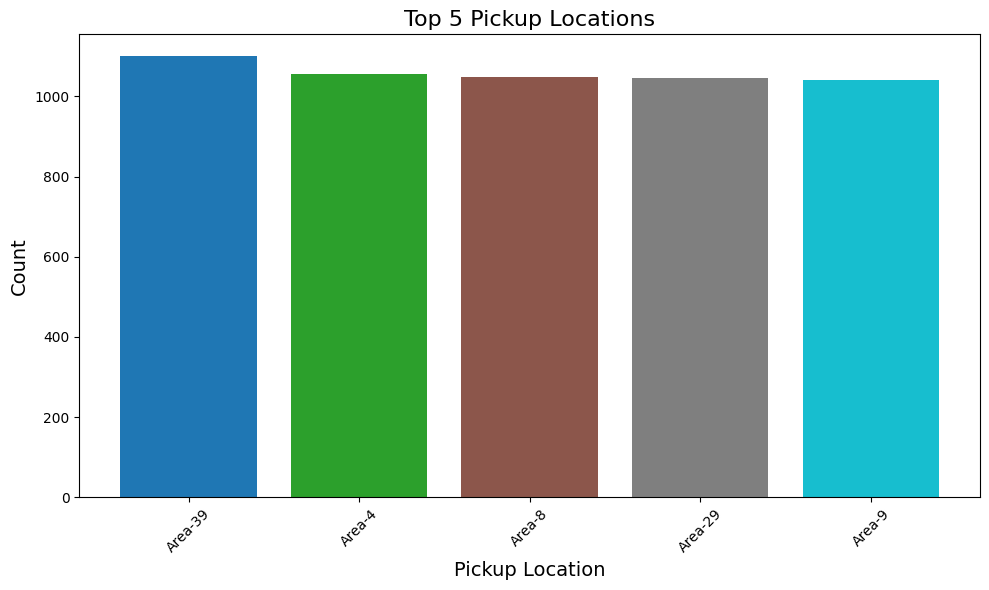

In [226]:
import matplotlib.pyplot as plt
import numpy as np

top_pickups = df_filled.groupBy("Pickup Location").count().orderBy("count", ascending=False).limit(5).toPandas()

colors = plt.get_cmap('tab10')(np.linspace(0, 1, len(top_pickups)))
plt.figure(figsize=(10,6))
bars = plt.bar(top_pickups["Pickup Location"], top_pickups["count"], color=colors)

plt.title("Top 5 Pickup Locations", fontsize=16)
plt.xlabel("Pickup Location", fontsize=14)
plt.ylabel("Count", fontsize=14)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [227]:
from pyspark.ml.regression import DecisionTreeRegressor

dtr = DecisionTreeRegressor(featuresCol="features", labelCol="label")
dtr_model = dtr.fit(train_data)
dtr_preds = dtr_model.transform(test_data)

dtr_rmse = evaluator_rmse.evaluate(dtr_preds)
print(f"Decision Tree RMSE: {dtr_rmse}")




Decision Tree RMSE: 569.3497773734262


In [228]:
from pyspark.ml.regression import RandomForestRegressor


rf = RandomForestRegressor(featuresCol="features", labelCol="label")
rf_model = rf.fit(train_data)
rf_preds = rf_model.transform(test_data)
rf_rmse = evaluator_rmse.evaluate(rf_preds)
print(f"Random Forest RMSE: {rf_rmse}")

Random Forest RMSE: 568.1699305673361


In [229]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=50)
gbt_model = gbt.fit(train_data)
gbt_preds = gbt_model.transform(test_data)

gbt_rmse = evaluator_rmse.evaluate(gbt_preds)
print(f"GBT RMSE: {gbt_rmse}")


GBT RMSE: 573.508767377852


In [230]:
from pyspark.ml.feature import StandardScaler

assembler = VectorAssembler(inputCols=features, outputCol="assembled_features")
scaler = StandardScaler(inputCol="assembled_features", outputCol="features")

assembled = assembler.transform(df_filtered)
scaled = scaler.fit(assembled).transform(assembled)
df_regression_ready = scaled.select("features", "Booking Value").withColumnRenamed("Booking Value", "label")


In [231]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.numTrees, [20, 50]) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_rmse,
                          numFolds=3)

rf_cv_model = crossval.fit(train_data)
rf_cv_preds = rf_cv_model.transform(test_data)

print("Tuned RF RMSE:", evaluator_rmse.evaluate(rf_cv_preds))


Tuned RF RMSE: 568.3333956397264


In [232]:
importances = rf_model.featureImportances
features_list = assembler.getInputCols()

for i, val in enumerate(importances):
    print(f"{features_list[i]}: {val:.4f}")


Avg VTAT: 0.2350
Avg CTAT: 0.1886
Ride Distance: 0.1992
Driver Ratings: 0.1603
Customer Rating: 0.2169


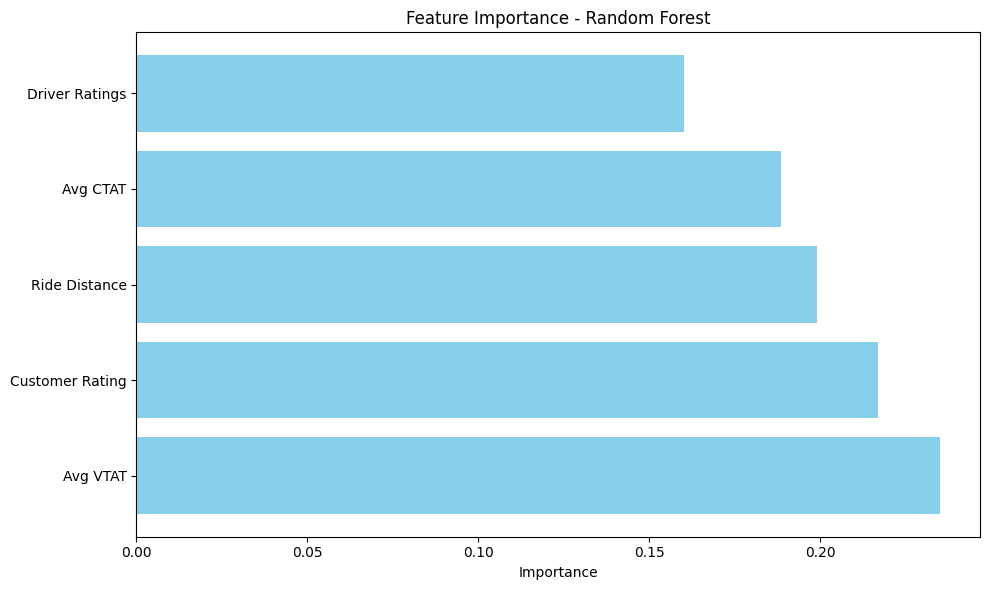

In [233]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

importances = rf_model.featureImportances.toArray()
features_list = assembler.getInputCols()

feature_importance_df = pd.DataFrame({
    'Feature': features_list,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [234]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=50)
gbt_model = gbt.fit(train_data)
gbt_preds = gbt_model.transform(test_data)

gbt_rmse = evaluator_rmse.evaluate(gbt_preds)
print(f"GBT RMSE: {gbt_rmse}")


GBT RMSE: 573.508767377852


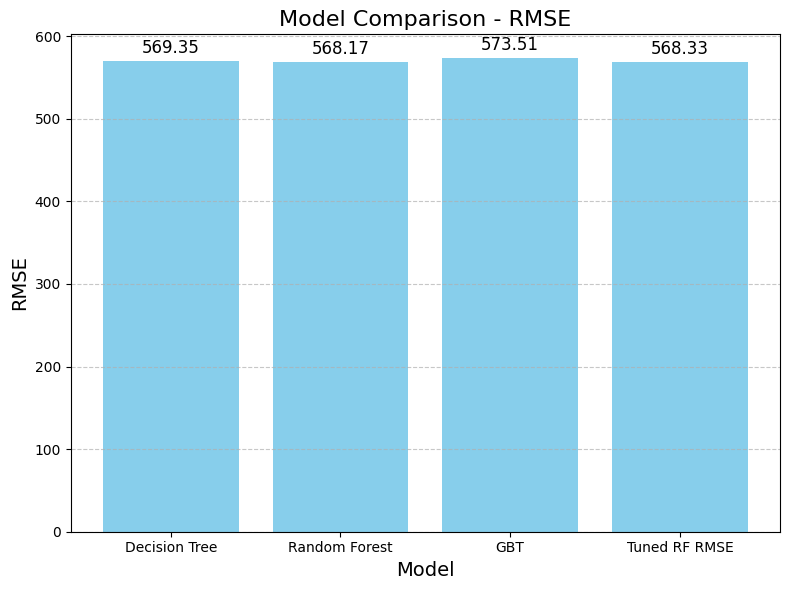

In [235]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="label", predictionCol="prediction")

rf_tuned_rmse = evaluator_rmse.evaluate(rf_cv_preds)

models = ["Decision Tree", "Random Forest", "GBT", "Tuned RF RMSE"]
rmses = [dtr_rmse, rf_rmse, gbt_rmse, rf_tuned_rmse]

plt.figure(figsize=(8, 6))
plt.bar(models, rmses, color='skyblue')

plt.title("Model Comparison - RMSE", fontsize=16)
plt.ylabel("RMSE", fontsize=14)
plt.xlabel("Model", fontsize=14)

plt.grid(True, axis='y', linestyle='--', alpha=0.7)

for i, rmse in enumerate(rmses):
    plt.text(i, rmse + 5, f"{rmse:.2f}", ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()
